In [1]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using function fitting.
Analysis of 500-mb geoptential height value on a polar stretographic projection



"""
__author__    = "Jared W. Marquis"
__edited_by__= "Sharhad Wainty"
__contact__   = "jared.marquis@und.edu"

In [2]:
# checking the envs
#needed to change the kernel to atsc528 in Jupyter notebook
!conda info --envs

/bin/bash: line 1: conda: command not found


In [3]:
#Used Colab for further works, supports Pip
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 42.1 MB/s eta 0:00:00


In [4]:
### Import Required Modules  ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

In [5]:
### Loaded the observation files from session storage on Colab###
data_path = '/content/RAOBs_201903131200.txt'
data = np.genfromtxt(data_path, delimiter=',', dtype=str)

# Individual columns for each data
station_ids = data[:, 0]  # Station IDs
station_lat = data[:, 1].astype(float)  # Latitude values
station_lon = data[:, 2].astype(float)  # Longitude values
heights = data[:, 3].astype(float)  # 500-mb Height


In [6]:
phi0 = np.radians(60)  # central latitude φ0 in radians
lambda0 = np.radians(-115)  # central longitude λ0 in radians
R = 6371*1000  # Earth's radius in meters
m = 1 / 15000000  # map scale

In [7]:
proj= ccrs.Stereographic(central_latitude=90, central_longitude=-115,true_scale_latitude=60)

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


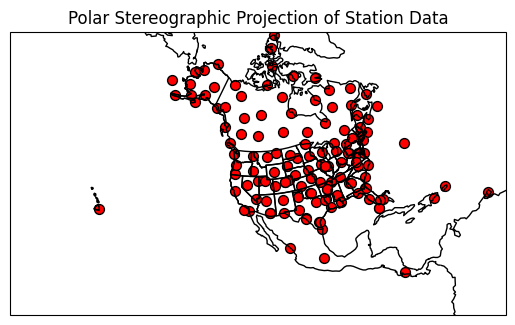

In [8]:
#Plotting the obs location on map
fig, ax = plt.subplots(subplot_kw={'projection': proj})

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.set_extent([station_lon.min() - 1, station_lon.max() + 1, station_lat.min() - 1, station_lat.max() + 1], crs=ccrs.PlateCarree())
ax.scatter(station_lon, station_lat, color='red', s=50, edgecolor='k', transform=ccrs.PlateCarree())
plt.title('Polar Stereographic Projection of Station Data')
plt.show()

Shape of x_grid: (22,)
Shape of y_grid: (28,)


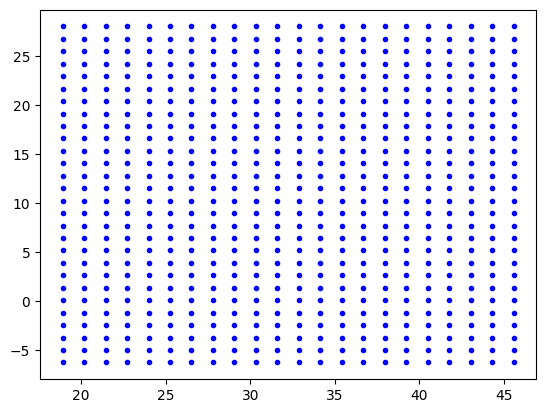

In [9]:
### Set up analysis map with a 22x28 rectangular grid of points ###
x0, y0 = 18.90, -6.30
dx, dy = 1.27, 1.27
nx, ny = 22,28
# Making a (22x28) grid
x_grid = np.linspace(x0, x0 + (nx - 1) * dx, nx)
y_grid = np.linspace(y0, y0 + (ny - 1) * dy, ny)

X, Y = np.meshgrid(x_grid, y_grid)
print("Shape of x_grid:", x_grid.shape)
print("Shape of y_grid:", y_grid.shape)
plt.scatter(X, Y, color='blue', label='Grid Points', marker='.')

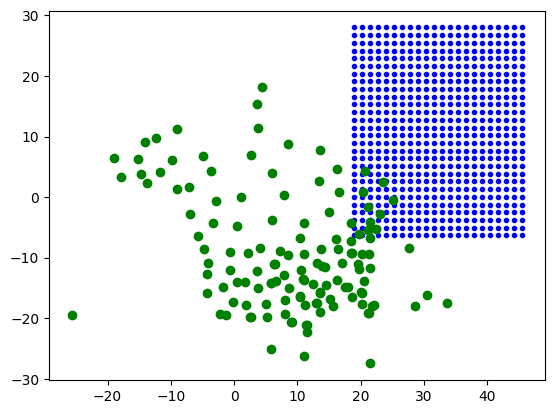

In [10]:
# Function to convert latitude and longitude to x, y in stereographic projection
def latlon_to_xy(station_lat, station_lon):
    lat_rad = np.radians(station_lat)
    lon_rad = np.radians(station_lon)


    # Calculating x and y
    x_obs = R * np.cos(lat_rad) * np.sin(lon_rad - lambda0) * m*100
    y_obs = R * (np.cos(phi0) * np.sin(lat_rad) - np.sin(phi0) * np.cos(lat_rad) * np.cos(lon_rad - lambda0)) * m*100

    return x_obs, y_obs

# Apply the function to all latitude and longitude values
obs_coords = np.array([latlon_to_xy(lat, lon) for lat, lon in zip(station_lat, station_lon)])

# Separate x and y coordinates
xk, yk = obs_coords[:, 0], obs_coords[:, 1]

#Plot the Stations and the Grid to Verify Alignment (I got wrong here somewhere)
plt.scatter(X, Y, color='blue', label='Grid Points', marker='.')  # Plot the grid points
plt.scatter(xk, yk, color='green', label='Converted Station Positions', marker='o')  # Plot station positions

I think my conversion of lat lon might be wrong as I assume the grid will fit in the extent where the stations are. But also the x0 and y0 of the analysis grid is not near the projection of minimum LAT and LON

In [11]:
# I had to take help of AI for this part for assigning weights solution for coefficients

def polynomial_fit(x_grid, y_grid, xk, yk, heights, roi):
    # Calculate distances between the grid point (x_grid, y_grid) and observation points (xk, yk)
    distances = np.sqrt((xk - x_grid)**2 + (yk - y_grid)**2)

    # Select points within the RoI (Radius of Influence), we need at least 3 points within the RoI for the analysis
    within_roi = distances <= roi
    num_observations = np.sum(within_roi)
    if num_observations < 3:
        return np.nan,num_observations


    # only points within the RoI
    xk_roi = xk[within_roi]
    yk_roi = yk[within_roi]
    heights_roi = heights[within_roi]

    # Gaussian weighting function based on RoI
    weights = np.exp(-((xk_roi - x_grid)**2 + (yk_roi - y_grid)**2) / (2 * roi**2))


    # Matrix A for second-order polynomial
    A = np.column_stack([
        np.ones_like(xk_roi),      # constant term
        xk_roi,                    # x
        yk_roi,                    # y
        xk_roi**2,                 # x^2
        yk_roi**2,                 # y^2
        xk_roi * yk_roi            # xy
    ])

    # Using weighted least squares
    W = np.diag(weights)  # Diagonal matrix of weights
    AtW = A.T @ W
    coeffs, _, _, _ = np.linalg.lstsq(AtW @ A, AtW @ heights_roi, rcond=None)  # Solving oefficients

    grid_value = (coeffs[0] +
                  coeffs[1] * x_grid +
                  coeffs[2] * y_grid +
                  coeffs[3] * x_grid**2 +
                  coeffs[4] * y_grid**2 +
                  coeffs[5] * x_grid * y_grid)

    return grid_value, num_observations


def perform_analysis(grid_points, x_obs, y_obs, heights, roi):

    grid_heights = np.zeros(len(grid_points))  # Initialize the grid height array
    num_observations = np.zeros(len(grid_points))

    for i, (x_grid, y_grid) in enumerate(grid_points):
        grid_heights[i],num_observations[i] = polynomial_fit(x_grid, y_grid, x_obs, y_obs, heights, roi)

    return grid_heights, num_observations

In [12]:
#Define the grid points in flat format for easier processing (Needed help of AI for this part)
flat_grid_points = np.vstack([X.ravel(), Y.ravel()]).T

# Analysis with RoI = 10 cm
roi_10cm = 10
grid_heights_10cm,num_obs_10cm = perform_analysis(flat_grid_points, xk, yk, heights, roi_10cm)

# Analysis with RoI = 20 cm
roi_20cm = 20
grid_heights_20cm, num_obs_20cm= perform_analysis(flat_grid_points, xk, yk, heights, roi_20cm)

# Step 4: Reshape grid heights back into 2D arrays for plotting (needed help from AI)
heights_10cm_reshaped = grid_heights_10cm.reshape(X.shape)
heights_20cm_reshaped = grid_heights_20cm.reshape(X.shape)
num_obs_10cm_reshaped = num_obs_10cm.reshape(X.shape)
num_obs_20cm_reshaped = num_obs_20cm.reshape(X.shape)



In [13]:
X_meters = X * 0.01  # Convert cm to meters
Y_meters = Y * 0.01  # Convert cm to meters

# grid x-y coordinates back to latitude and longitude
x_squared_y_squared = X_meters**2 + Y_meters**2
lambda_grid = lambda0 + np.arctan2(X_meters, Y_meters)
phi_grid = np.arcsin((1 - x_squared_y_squared / (2 * R * m)**2) / (1 + x_squared_y_squared / (2 * R * m)**2))

# Convert to degrees
latitude_grid = np.degrees(phi_grid)
longitude_grid = np.degrees(lambda_grid)

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


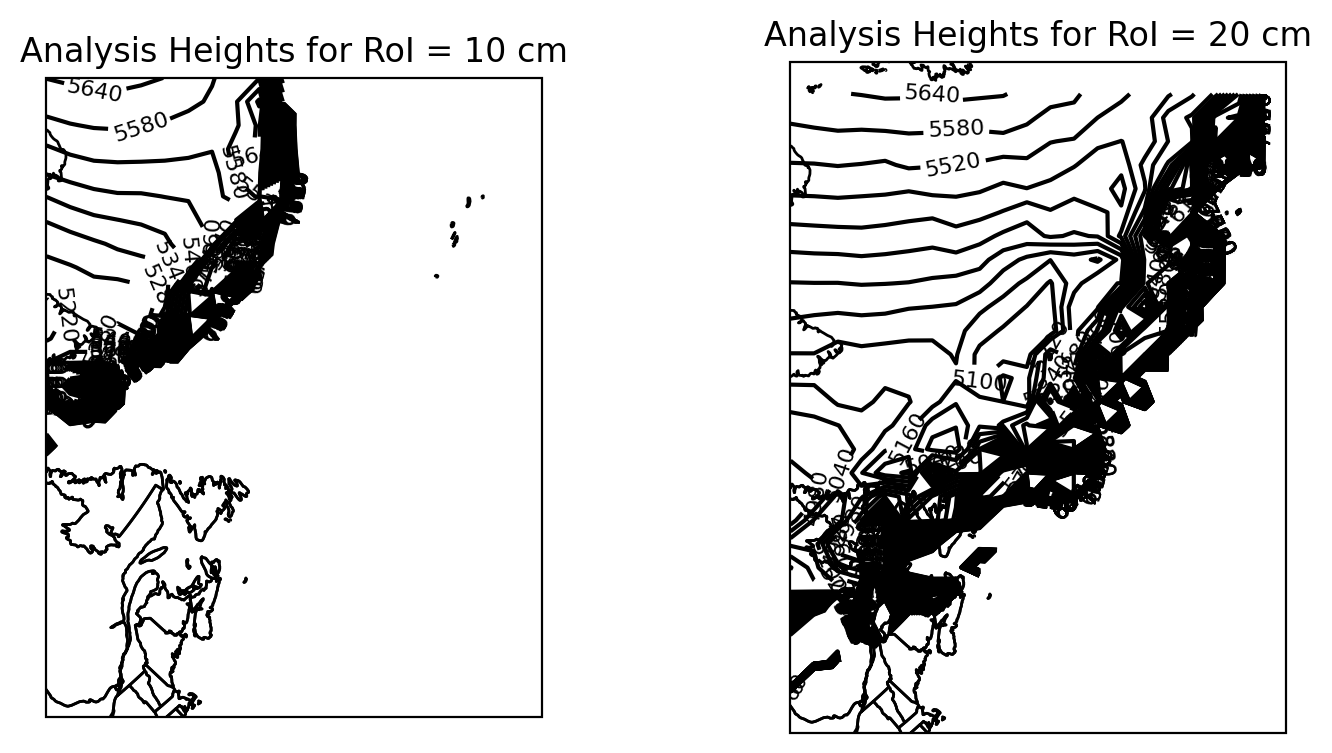

In [14]:
#Plot 500-mb analysis contour map
fig = plt.figure(figsize=(8, 8), dpi=200)

ax1 = fig.add_subplot(1, 2, 1, projection=proj)
ax2 = fig.add_subplot(1, 2, 2, projection=proj)
plt.subplots_adjust(wspace=0.5)

#For RoI 10 cm
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.STATES)
ax1.set_title('Analysis Heights for RoI = 10 cm')
cs1 = ax1.contour(longitude_grid, latitude_grid, heights_10cm_reshaped, colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60),fontsize=8)

#For RoI 20 cm
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.STATES)
ax2.set_title('Analysis Heights for RoI = 20 cm')
cs2 = ax2.contour(longitude_grid, latitude_grid, heights_20cm_reshaped, colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs2,levels=np.arange(0,8000,60),fontsize=8)

plt.show()


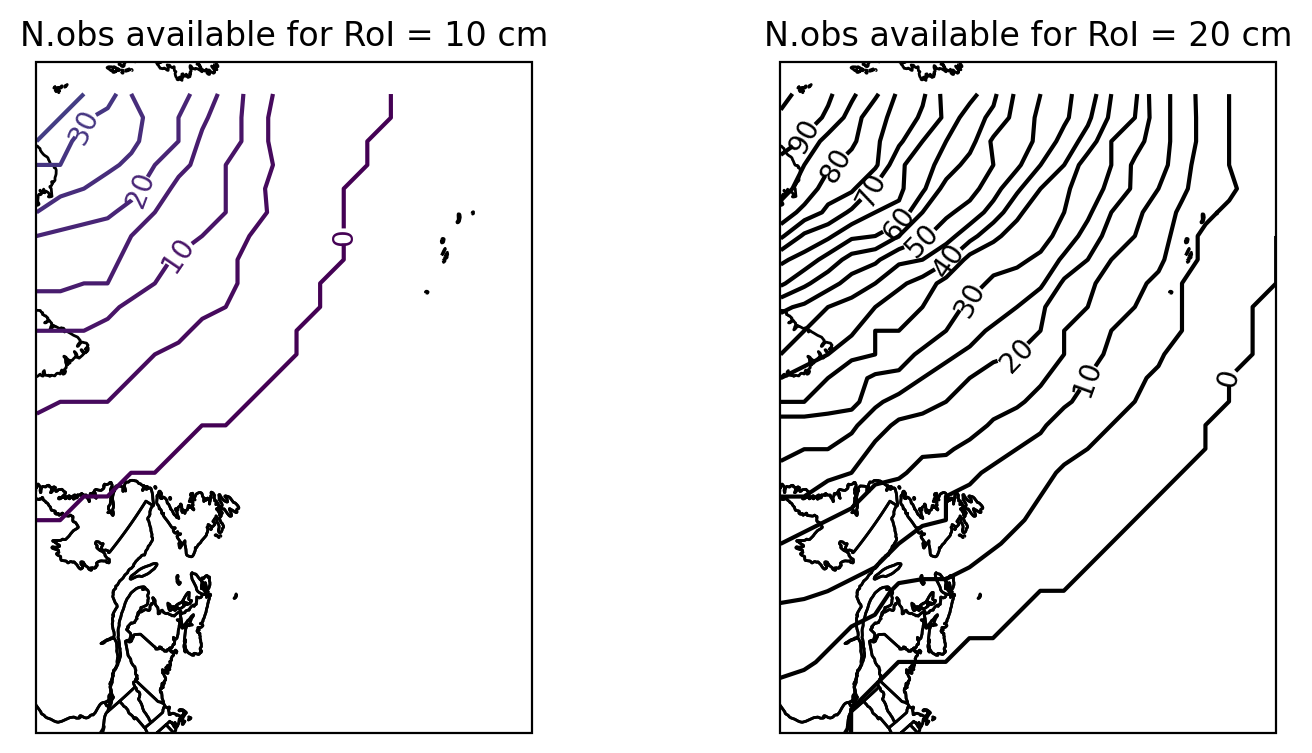

In [15]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
fig = plt.figure(figsize=(8, 8), dpi=200)

# Create subplots with 1 row and 2 columns
ax1 = fig.add_subplot(1, 2, 1, projection=proj)
ax2 = fig.add_subplot(1, 2, 2, projection=proj)
plt.subplots_adjust(wspace=0.5)  # Increase the value to increase the gap


#For RoI 10 cm
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.STATES)
ax1.set_title('N.obs available for RoI = 10 cm')
cs1 = ax1.contour(longitude_grid, latitude_grid, num_obs_10cm_reshaped,levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))

#For RoI 20 cm
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.STATES)
ax2.set_title('N.obs available for RoI = 20 cm')
cs2 = ax2.contour(longitude_grid, latitude_grid, num_obs_20cm_reshaped, colors='k',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs2,levels=np.arange(0,200,10))

plt.show()


In [16]:
### Store the analyses in text files ###

file_10cm = 'analysis_10cm.txt'
file_20cm = 'analysis_20cm.txt'

np.savetxt(file_10cm, heights_10cm_reshaped, fmt='%.2f', delimiter=',', header='500mb Geopotential Height (RoI = 10cm)', comments='')
np.savetxt(file_20cm, heights_20cm_reshaped, fmt='%.2f', delimiter=',', header='500mb Geopotential Height (RoI = 20cm)', comments='')


In [17]:
### Store the number of observations available for each grid point in text files ###
obs_file_10cm = 'observations_10cm.txt'
obs_file_20cm = 'observations_20cm.txt'
num_obs_10cm_reshaped = np.nan_to_num(num_obs_10cm_reshaped, nan=0)  #replacing NaN values as 0
num_obs_20cm_reshaped = np.nan_to_num(num_obs_20cm_reshaped, nan=0)

np.savetxt(obs_file_10cm, num_obs_10cm_reshaped, fmt='%d', delimiter=',', header='Number of Observations (RoI = 10cm)', comments='')
np.savetxt(obs_file_20cm, num_obs_20cm_reshaped, fmt='%d', delimiter=',', header='Number of Observations (RoI = 20cm)', comments='')


1 - **Describe the general features that you see in your contoured analyses.**


Answer:

*Predicted heights ROI 10cm:* the contour for this map extends from 5200 t0 5600-mb. Observations within 10 cm each grid point are considered for the polynomial fit.

*Predicted heights ROI 20cm:* More data points within the RoI=20 cm are used in the polynomial fitting leading to smooth fits.

*Number of observations at ROI 10cm:* he number of observations available for fitting is relatively small. Near the edgesthe number of available observations is zero or very low.

*Number of observations at ROI 20cm:* For most grid points, there are many more observations available (ranging from 10 to as high as 90 in some areas)."



**2 - Describe the differences that you see in your contoured analyses.
    Does one analysis seem to be smoother than the other?  If so, what would cause this?**

Answer: An analysis point is only going to be affected by the observations within a region of influence around the analysis point AS RoI 20 cm>10 cm, more observation data oints are considered for the countour analysis. This improves the analysis giving a more accurate representation of 500-mb contour plot.The smaller RoI of 10 am leads to an unstable or noisy fit, as the number of observations is very low, almost 0 near the right edges, compared to RoI-20 cm. The contour lines are more evenly spaced for RoI 20 cm, indicating consistent analysis across the grid."



**3 - Run your program using a radius of influence of 6 cm (do not need to show).
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them?**

Answer: The result doesn't look realistic at all. As the ROI is very small, the edge of the contour plane gets too noisy. The very small RoI cause this noisy result due to insufficient data point. The area of coverage for RoI 6 cm is very small too making the contour lines have very big gaps between.

**4 - Suppose you ran this program with a small enough radius of influence that only one
    observation was available for determining a polynomial fit at a grid point.  Should
    you be able to perform the matrix inversion?  Why or why not?**
    
Answer: We wont be able to run his program for one grid point only. 2 Degree polynomial quadratic equations will need at least 3 data points for 6 unknown polynomial coefficient.